Julia

Comenzaremos usando Julia y lo primero que haremos será importar los paquetes necesarios para que funcione el programa.

In [ ]:
import Pkg;
Pkg.add("DeconvOptim")
Pkg.add("TestImages")
Pkg.add("Colors")
Pkg.add("ImageIO")
Pkg.add("Noise")
Pkg.add("ImageShow")
Pkg.add("Images")
Pkg.add("FFTW")
Pkg.add("Plots")
Pkg.add("BenchmarkTools")
Pkg.add("Revise")
Pkg.add("ImageView")
Pkg.add("OffsetArrays")

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.

In [1]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools

# Cargar la imagen de prueba
img = load("ImagenPrueba.jpg")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Crear una versión borrosa y ruidosa de la imagen
img_b = conv(img, psf)  # Imagen borrosa
img_n = poisson(img_b, 300)  # Imagen borrosa y ruidosa

# Guardar la imagen borrosa y ruidosa
save("blurrednoisy_img.jpg", img_b)

# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución

b = @benchmark  deconvolution(img_n, psf, regularizer=nothing, iterations=30) samples=15 evals=1


BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  224.208 ms … 352.211 ms  ┊ GC (min … max):  1.26% … 35.02%
 Time  (median):     237.170 ms               ┊ GC (median):     5.90%
 Time  (mean ± σ):   276.907 ms ±  57.973 ms  ┊ GC (mean ± σ):  18.88% ± 16.15%

  █     █                                                        
  █▁▇▇▁▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▁▇▇▇ ▁
  224 ms           Histogram: frequency by time          352 ms <

 Memory estimate: 172.58 MiB, allocs estimate: 5827.

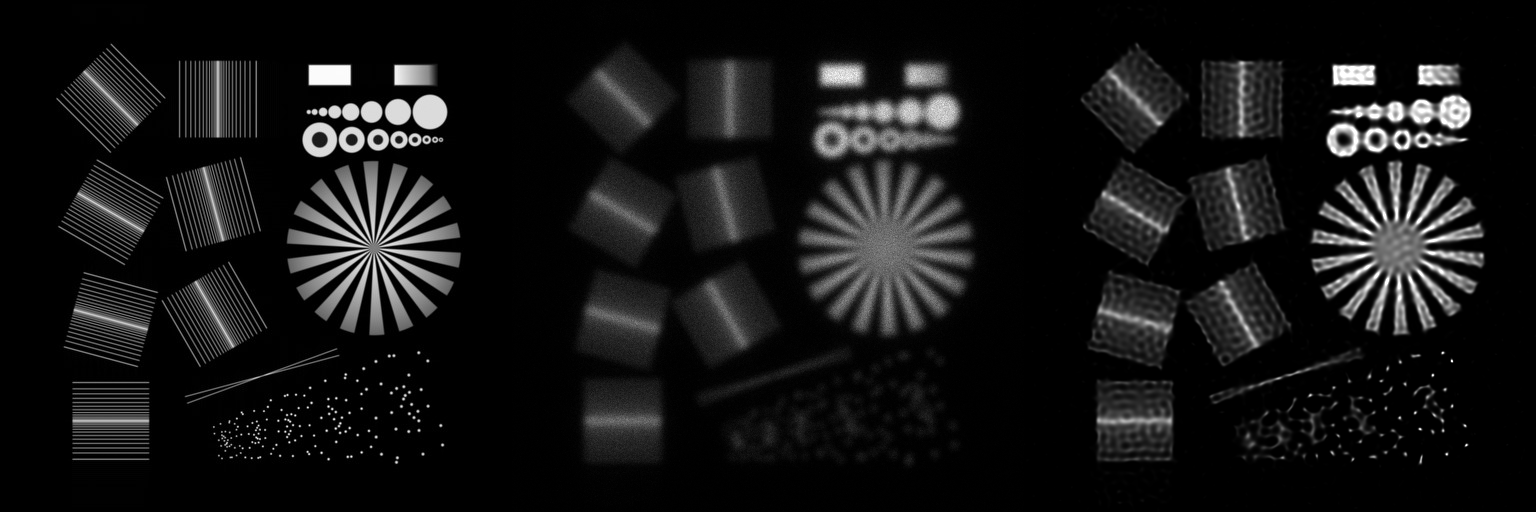

In [2]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n res_no_reg])

ifftshift: Es una función utilizada en el contexto de transformadas de Fourier inversas (inversa de la Transformada de Fourier Discreta, DFT por sus siglas en inglés). Esta función reordena los elementos de un array de manera que el centro del arreglo (frecuencia cero) se desplace al inicio del array. Esto es crucial para asegurar que al realizar la inversa de una DFT, el resultado esté centrado de manera adecuada.

En nuestro caso la función de Julia generate_psf() genera una PSF la cual quedan las diagonales intercambiadas, si queremos guardar la PSF centrada tenemos que usar la función ifftshift

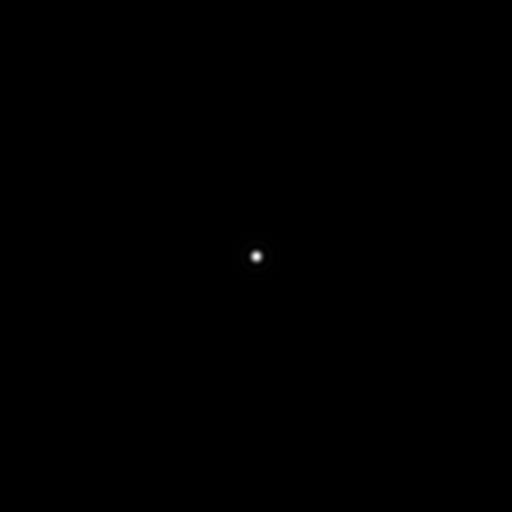

In [3]:
using FFTW, ImageIO, Colors, Images

# Suponemos que psf ya está definida
# Normaliza los valores de la PSF al rango [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
psf_gray = Gray.(psf_normalized)  # Convertir a escala de grises

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)
centered_psf_gray = Gray.(centered_psf)  # Convertir a escala de grises

# Guardar la PSF normalizada como una imagen JPEG
save("psf.jpg", centered_psf_gray)

# Mostrar la PSF centrada
display(centered_psf_gray)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [4]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30)
c = @benchmark richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30) samples=100 evals=1

BenchmarkTools.Trial: 83 samples with 1 evaluation.
 Range (min … max):  58.487 ms … 76.143 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     59.704 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   59.988 ms ±  2.217 ms  ┊ GC (mean ± σ):  0.58% ± 1.81%

   ▃█     ▅▂▁                                                  
  ▆██▄▄▁▆▇███▃▄▁▃▃▃▅▁▁▃▃▁▁▁▃▁▁▁▁▃▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▁
  58.5 ms         Histogram: frequency by time        67.1 ms <

 Memory estimate: 7.01 MiB, allocs estimate: 33.

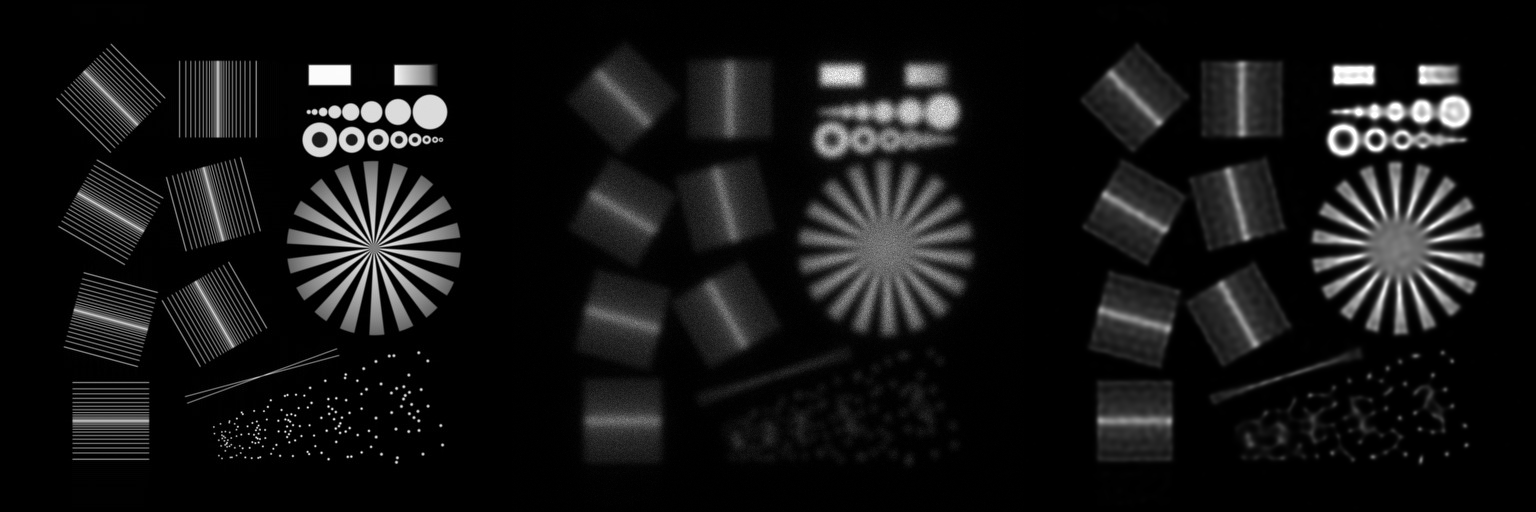

In [6]:
Gray.([img img_n restored_img])

Veremos ahora ejemplos con TV regularization en Julia

In [5]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=20)
d = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=20) samples=15 evals=1


BenchmarkTools.Trial: 15 samples with 1 evaluation.
 Range (min … max):  261.922 ms … 285.370 ms  ┊ GC (min … max): 2.22% … 2.21%
 Time  (median):     267.873 ms               ┊ GC (median):    2.35%
 Time  (mean ± σ):   270.211 ms ±   6.665 ms  ┊ GC (mean ± σ):  2.76% ± 0.80%

  ▁ ▁ ▁   ▁  █▁  ▁         █ ▁    ▁        ▁▁                 ▁  
  █▁█▁█▁▁▁█▁▁██▁▁█▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  262 ms           Histogram: frequency by time          285 ms <

 Memory estimate: 66.61 MiB, allocs estimate: 633692.

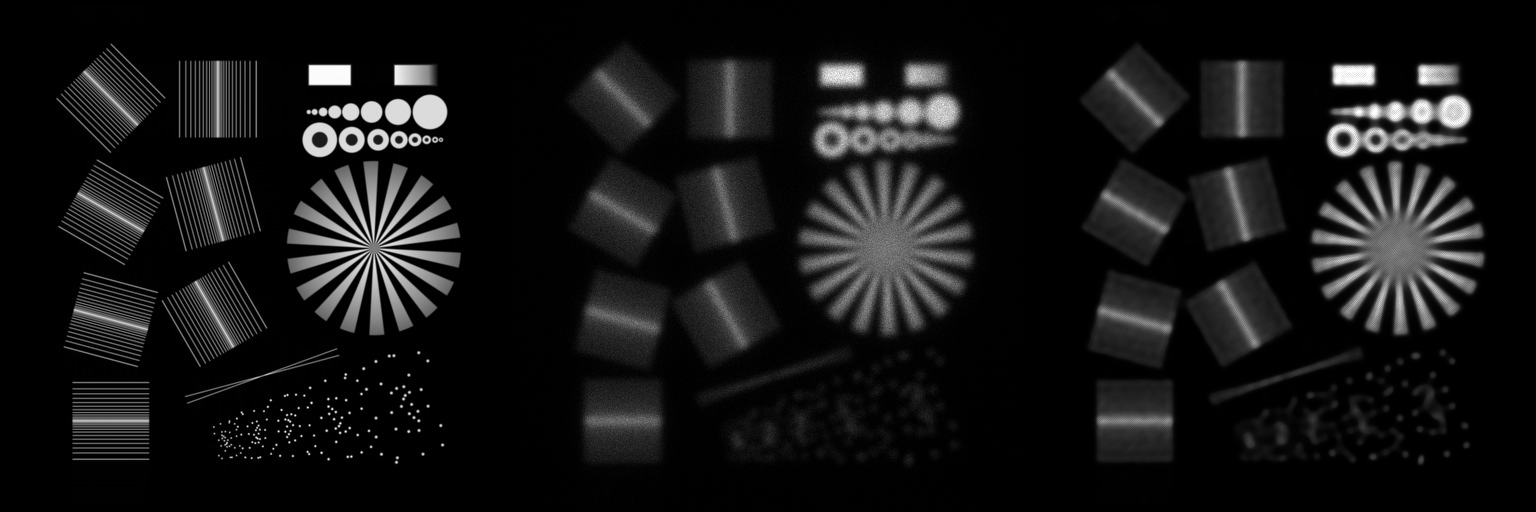

In [7]:
Gray.([img img_n optim_res])

Python

In [ ]:
pip install numpy matplotlib scipy scikit-image imageio

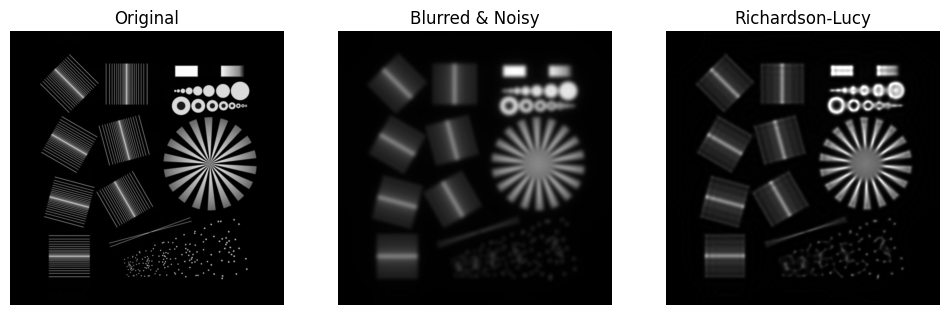

In [1]:
import numpy as np
from skimage import img_as_float
from skimage.restoration import richardson_lucy
import matplotlib.pyplot as plt
import imageio.v2 as iio

# Cargar las imágenes
imgP = img_as_float(iio.imread("ImagenPrueba.jpg"))
psfP = img_as_float(iio.imread("psf.jpg"))
imgP_n = img_as_float(iio.imread("blurrednoisy_img.jpg"))

# Deconvolución de la imagen usando el algoritmo de Richardson-Lucy
res = richardson_lucy(imgP_n, psfP, num_iter=30)

# Mostrar las imágenes original, borrosa y deconvolucionada
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(imgP, cmap='gray')
plt.title('Original')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

plt.subplot(1, 3, 2)
plt.imshow(imgP_n, cmap='gray')
plt.title('Blurred & Noisy')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

plt.subplot(1, 3, 3)
plt.imshow(res, cmap='gray')
plt.title('Richardson-Lucy')
plt.axis('off')  # Ocultar los ejes para una mejor visualización

plt.show()


Medimos ahora el tiempo de la función richardson_lucy()

In [2]:
%timeit -n 1 -r 30 richardson_lucy(imgP_n, psfP, num_iter=30)

796 ms ± 7.34 ms per loop (mean ± std. dev. of 30 runs, 1 loop each)


JULIA EN 3D

Probamos con el código de prueba

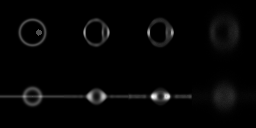

In [71]:
using Revise, DeconvOptim, TestImages, Images, FFTW, Noise, ImageView
img3d = convert(Array{Float32}, testimage("simple_3d_ball"))
psf3d = permutedims(ifftshift(OffsetArrays.no_offset_view(
            Float32.(testimage("simple_3d_psf")))), (3,1,2))
psf3d ./= sum(psf3d)
# create a blurred, noisy version of that image
img3d_b = conv(img3d, psf3d, [1, 2, 3])
img3d_n = poisson(img3d_b, 300);

reg1 = TV(num_dims=3, sum_dims=[1, 2, 3])
reg2 = Tikhonov(num_dims=3, sum_dims=[1, 2, 3], mode="identity")

res, ores = deconvolution(img3d, psf3d, regularizer=reg1, loss=Poisson(),
                          λ=0.05, padding=0.2, iterations=10);
res2, ores = deconvolution(img3d, psf3d, regularizer=reg2, loss=Poisson(),
                          λ=0.001, padding=0.0, iterations=10);

img3d_comb1 = [img3d[:, : ,32] res2[:, :, 32] res[:, :, 32] img3d_n[:, :, 32]]
img3d_comb2 = [img3d[:, : ,43] res2[:, :, 43] res[:, :, 43] img3d_n[:, :, 43]]
                          
img3d_comb = cat(img3d_comb1, img3d_comb2, dims=1)
img3d_comb ./= maximum(img3d_comb)

Gray.(img3d_comb)
                          

In [72]:
b = @benchmark deconvolution(img3d, psf3d, regularizer=reg1, loss=Poisson(), λ=0.05, padding=0.2, iterations=10) samples=15 evals=1

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  367.144 ms … 380.166 ms  ┊ GC (min … max): 0.90% … 2.41%
 Time  (median):     372.858 ms               ┊ GC (median):    1.24%
 Time  (mean ± σ):   373.403 ms ±   4.091 ms  ┊ GC (mean ± σ):  1.57% ± 0.50%

  █ █           ██    █    ██      █    █  █     █        █   █  
  █▁█▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁█▁▁▁▁██▁▁▁▁▁▁█▁▁▁▁█▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  367 ms           Histogram: frequency by time          380 ms <

 Memory estimate: 456.45 MiB, allocs estimate: 3130.

In [73]:
b = @benchmark deconvolution(img3d, psf3d, regularizer=reg2, loss=Poisson(), λ=0.05, padding=0.2, iterations=10) samples=15 evals=1

BenchmarkTools.Trial: 14 samples with 1 evaluation.
 Range (min … max):  343.593 ms … 357.750 ms  ┊ GC (min … max): 0.64% … 2.92%
 Time  (median):     353.361 ms               ┊ GC (median):    1.42%
 Time  (mean ± σ):   352.470 ms ±   3.724 ms  ┊ GC (mean ± σ):  1.85% ± 0.87%

  ▁                    ▁      ▁█ ▁        ▁   ▁▁▁▁     ▁  ▁   ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁██▁█▁▁▁▁▁▁▁▁█▁▁▁████▁▁▁▁▁█▁▁█▁▁▁█ ▁
  344 ms           Histogram: frequency by time          358 ms <

 Memory estimate: 522.55 MiB, allocs estimate: 2612.

Aqui vamos a probar con la imagen que viene del código de MATLAB, para ello necesitamos ajustar las imagenes para que tengan las mismas dimensiones. He traducido la función align_size a Julia

In [76]:
function align_size(img1, Sx2, Sy2, Sz2, padValue=0.0f0)
    # Obtener las dimensiones de la imagen de entrada
    Sx1, Sy1, Sz1 = size(img1)
    
    # Calcular las dimensiones máximas
    Sx = max(Sx1, Sx2)
    Sy = max(Sy1, Sy2)
    Sz = max(Sz1, Sz2)
    
    # Crear una imagen temporal con el valor de relleno
    imgTemp = fill(padValue, Sx, Sy, Sz)
    
    # Calcular los offsets para centrar la imagen de entrada en imgTemp
    Sox = round(Int, (Sx - Sx1) / 2) + 1
    Soy = round(Int, (Sy - Sy1) / 2) + 1
    Soz = round(Int, (Sz - Sz1) / 2) + 1
    
    # Posicionar la imagen de entrada en el centro de imgTemp
    imgTemp[Sox:Sox+Sx1-1, Soy:Soy+Sy1-1, Soz:Soz+Sz1-1] = img1
    
    # Calcular los offsets para centrar y recortar imgTemp a las dimensiones objetivo
    Sox = round(Int, (Sx - Sx2) / 2) + 1
    Soy = round(Int, (Sy - Sy2) / 2) + 1
    Soz = round(Int, (Sz - Sz2) / 2) + 1
    
    # Recortar la imagen temporal a las dimensiones objetivo
    img2 = imgTemp[Sox:Sox+Sx2-1, Soy:Soy+Sy2-1, Soz:Soz+Sz2-1]
    
    return img2
end


align_size (generic function with 2 methods)

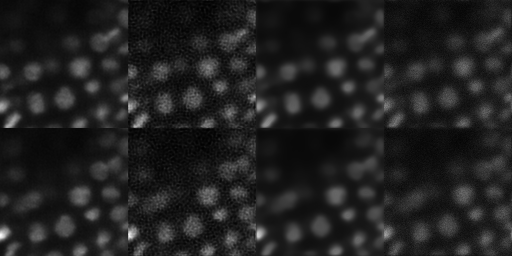

In [81]:
using Revise, DeconvOptim, TestImages, Images, FFTW, Noise, ImageView, OffsetArrays

imgJ = convert(Array{Float32}, channelview(load("Stack_1.tif")))
psfJ = ifftshift(convert(Array{Float32}, channelview(load("PSF.tif"))))
psfJ ./= sum(psfJ)

# Asegúrate de que imgJ y psfJ tengan las dimensiones compatibles
imgJ_size = size(imgJ)
psfJ_size = size(psfJ)

if any(imgJ_size .< psfJ_size)
    error("El tamaño de la psfJ es mayor que el tamaño de la imagen en alguna dimensión.")
end

# Ajustar la imgJ para que tenga las mismas dimensiones que la psfJ
imgJ = align_size(imgJ, size(psfJ, 1), size(psfJ, 2), size(psfJ, 3))

# Crear una versión borrosa y ruidosa de la imagen
imgJ_b = conv(imgJ, psfJ, [1, 2, 3])
imgJ_n = poisson(imgJ_b, 300)

#Regularizadores

reg1 = TV(num_dims=3, sum_dims=[1, 2, 3])
reg2 = Tikhonov(num_dims=3, sum_dims=[1, 2, 3], mode="identity")


# Deconvoluciones
res1J, _ = deconvolution(imgJ_n, psfJ, regularizer=reg1, loss=Poisson(),λ=0.05, padding=0.2, iterations=20)
res2J, _ = deconvolution(imgJ_n, psfJ, regularizer=reg2, loss=Poisson(),λ=0.001, padding=0.0, iterations=20)

# Encuentra las dimensiones mínimas comunes
min_x = minimum([size(imgJ, 1), size(res1J, 1), size(res2J, 1), size(imgJ_n, 1)])
min_y = minimum([size(imgJ, 2), size(res1J, 2), size(res2J, 2), size(imgJ_n, 2)])
min_z = minimum([size(imgJ, 3), size(res1J, 3), size(res2J, 3), size(imgJ_n, 3)])

# Ajustar imágenes a las dimensiones mínimas
imgJ_cropped = align_size(imgJ, min_x, min_y, min_z)
res1J_cropped = align_size(res1J, min_x, min_y, min_z)
res2J_cropped = align_size(res2J, min_x, min_y, min_z)
imgJ_n_cropped = align_size(imgJ_n, min_x, min_y, min_z)

# Selecciona índices de corte
slice_idx1 = 32
slice_idx2 = 38

# Asegúrate de que los índices estén dentro del rango de las dimensiones mínimas
slice_idx1 = min(slice_idx1, min_z)
slice_idx2 = min(slice_idx2, min_z)

imgJ_comb1 = hcat(imgJ_cropped[:, :, slice_idx1], res2J_cropped[:, :, slice_idx1], res1J_cropped[:, :, slice_idx1], imgJ_n_cropped[:, :, slice_idx1])
imgJ_comb2 = hcat(imgJ_cropped[:, :, slice_idx2], res2J_cropped[:, :, slice_idx2], res1J_cropped[:, :, slice_idx2], imgJ_n_cropped[:, :, slice_idx2])

imgJ_comb = vcat(imgJ_comb1, imgJ_comb2)
imgJ_comb ./= maximum(imgJ_comb)

imshow(imgJ_comb)
colorview(Gray, imgJ_comb)  

In [84]:
e = @benchmark deconvolution(imgJ_n, psfJ, regularizer=reg1, loss=Poisson(),λ=0.05, padding=0.2, iterations=20)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.431 s (6.63% GC) to evaluate,
 with a memory estimate of 5.96 GiB, over 5865 allocations.